This is the final notebook that produces the RABASAR (or multi-temporal despeckled) products. The main ingredients summarized are:

1. reading the time series of images as `time_series`.
2. reading the temporally averaged reference `temporal_average`.
3. Forming the ratios `ratios = [img / temporal_average for img in time_series]`.
4. Spatial de-speckling the ratio using the model from the [paper](https://ieeexplore.ieee.org/document/8602457) to obtain `ratio_despeckled`
5. Reconstructing the de-speckled images as `[ratio * temporal_average for ratio in ratios]`

The algorithm is summarized best from figure 1 from the paper above:

[![](https://weiyingzhao.github.io/images/flowchart2.png)](https://weiyingzhao.github.io//RABASAR/)


### Notes

+ We need to specify a weight for the denoised regularized temporally averaged reference image; this is how we will determine it's file name using a previous notebook.
+ We remind users that we have a single temporally average image for the entire time series since we do not perform change detection.
+ Note our "temporally averaged reference" is what the paper calls the "super-image."

In [1]:
import rasterio
import numpy
import scipy
from rabasar import (admm_ratio_denoise, 
                     interpolate_nn, 
                     get_enl_img, 
                     get_enl_mode, 
                     get_enl_mask,
                     scale_img)
from itertools import starmap
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Read Config File

In [2]:
config_dict = json.load(open('config.json', 'r'))
config_dict

{'sensor': 'uavsar', 'site': 'waxlake', 'regularizer': 'tv'}

In [3]:
SENSOR = config_dict['sensor']
SITE = config_dict['site']
REGULARIZER = config_dict['regularizer']

In [4]:
WEIGHT = 1.

# Data Paths

In [5]:
ta_image_dir_name = f'out/{SENSOR}_{SITE}_{REGULARIZER}/temporally_averaged_image_{REGULARIZER}/weight_{WEIGHT:1.2f}'
TEMPORALLY_AVERAGED_IMAGE_DIR_TV = Path(ta_image_dir_name)
TEMPORALLY_AVERAGED_IMAGE_DIR_TV.exists()

True

In [6]:
data_dir_path_name = f'{SENSOR}_{SITE}/data_reprojected'
if REGULARIZER != 'tv':
    data_dir_path_name += '_tv'
DATA_DIR = Path(data_dir_path_name)
DATA_DIR.exists()

True

In [7]:
RATIO_DIR =Path(f'out/{SENSOR}_{SITE}_{REGULARIZER}/rabasar_{REGULARIZER}')
RATIO_DIR.mkdir(exist_ok=True, parents=True)

In [8]:
hh_paths = sorted(list(DATA_DIR.glob('*/*hh*.tif')))
hv_paths = sorted(list(DATA_DIR.glob('*/*hv*.tif')))
vv_paths = sorted(list(DATA_DIR.glob('*/*vv*.tif')))

hv_paths

[PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190620.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190701.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190716.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190725.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190812.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190923.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190930.tif')]

In [9]:
ta_tv_paths = sorted(list(TEMPORALLY_AVERAGED_IMAGE_DIR_TV.glob('*.tif')))
ta_tv_paths

[PosixPath('out/uavsar_waxlake_tv/temporally_averaged_image_tv/weight_1.00/waxlake_uavsar_temporally_average_hh_tv_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/temporally_averaged_image_tv/weight_1.00/waxlake_uavsar_temporally_average_hv_tv_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/temporally_averaged_image_tv/weight_1.00/waxlake_uavsar_temporally_average_vv_tv_1.00.tif')]

# Opening data

In [10]:
def open_one(path):
    with rasterio.open(path) as ds:
        img = ds.read(1)
    return img

ta_tv_reference_images = list(map(open_one, ta_tv_paths))

In [11]:
with rasterio.open(ta_tv_paths[0]) as ds:
    profile = ds.profile

# Subset and Display

In [12]:
if SITE == 'waxlake' and SENSOR == 'uavsar' and REGULARIZER == 'tv':
    sy = np.s_[-2000:-1000]
    sx = np.s_[-3000:-2000]
else:
    raise NotImplementedError

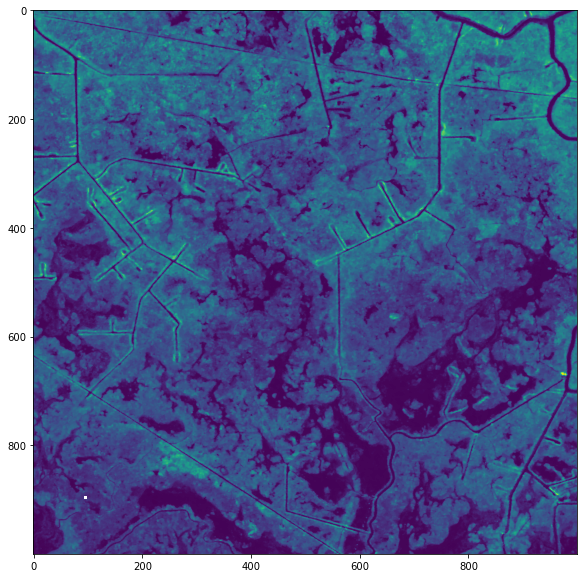

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(ta_tv_reference_images[0][sy, sx])

In [14]:
def read_arr(path):
    with rasterio.open(path) as ds:
        arr = ds.read(1)
    arr = np.clip(arr, 0, 1)
    return arr
hh_ts = list(map(read_arr, hh_paths))
hv_ts = list(map(read_arr, hv_paths))
vv_ts = list(map(read_arr, vv_paths))

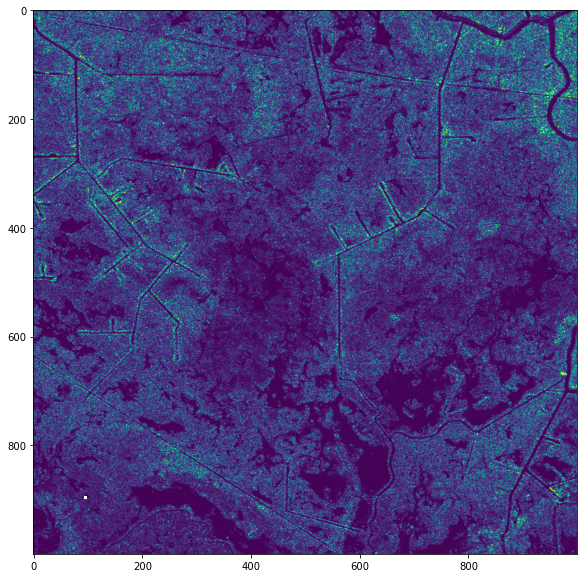

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(hh_ts[0][sy, sx])

## Reading the Temporally Averaged Reference Images

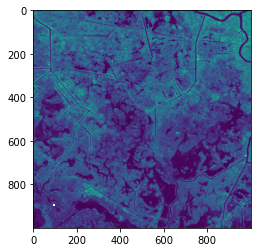

In [16]:
ta_reference_image_hh = np.clip(ta_tv_reference_images[0],  1e-5, 1)
ta_reference_image_hv = np.clip(ta_tv_reference_images[1],  1e-5, 1)
ta_reference_image_vv = np.clip(ta_tv_reference_images[2],  1e-5, 1)
plt.imshow(ta_reference_image_hh[sy, sx])

# Forming the Ratio Images

In [17]:
def ratio_hh(img):
    return np.clip(img / ta_reference_image_hh, 1e-3, 10)
def ratio_hv(img):
    return np.clip(img / ta_reference_image_hv, 1e-3, 10)
def ratio_vv(img):
    return np.clip(img / ta_reference_image_vv, 1e-3, 10)

ratio_hh_ts = list(map(ratio_hh, tqdm(hh_ts)))
ratio_hv_ts = list(map(ratio_hv, tqdm(hv_ts)))
ratio_vv_ts = list(map(ratio_vv, tqdm(vv_ts)))

100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


We fill in the nodata areas (`np.nan`) with their nearest neighbor value to allow the spatial despeckler to work.

In [18]:
ratio_hh_ts_nn = list(map(interpolate_nn, tqdm(ratio_hh_ts)))
ratio_hv_ts_nn = list(map(interpolate_nn, tqdm(ratio_hv_ts)))
ratio_vv_ts_nn = list(map(interpolate_nn, tqdm(ratio_vv_ts)))

100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Let's see what the ratio images look like.

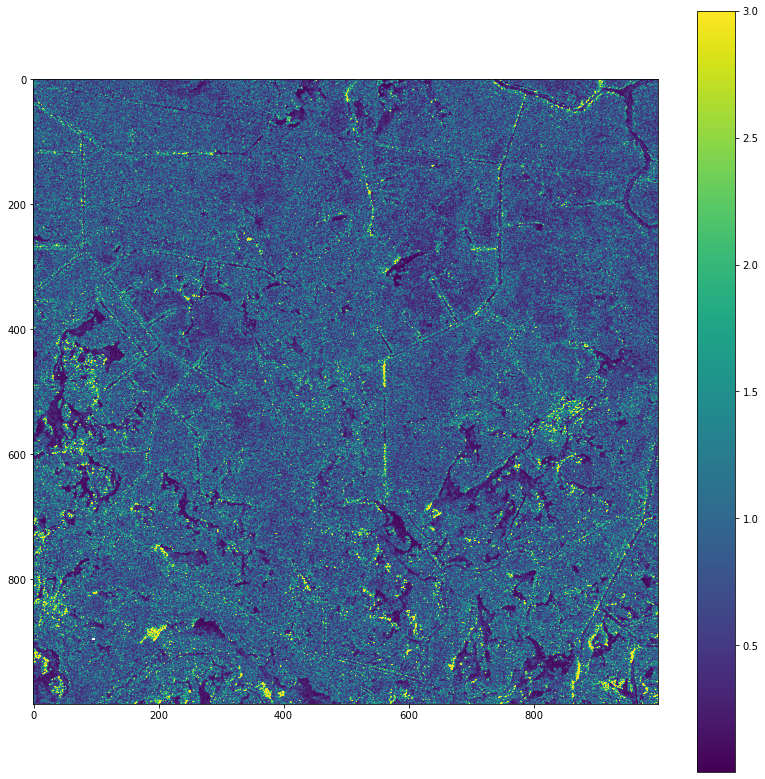

In [19]:
plt.figure(figsize=(14, 14))
plt.imshow(ratio_hh_ts[-1][sy, sx], vmax=3)
plt.colorbar()

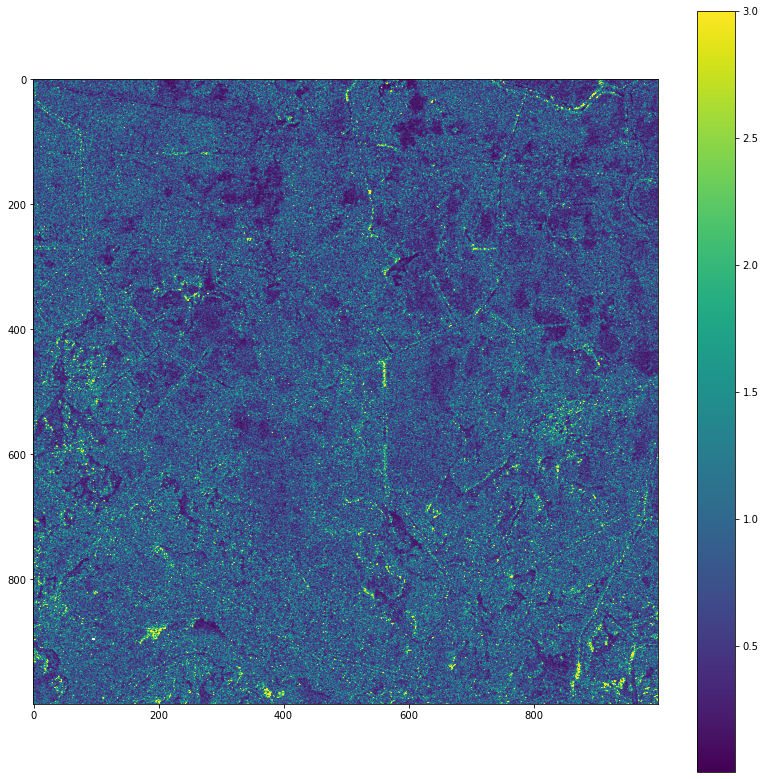

In [20]:
plt.figure(figsize=(14, 14))
plt.imshow(ratio_hv_ts[-1][sy, sx], vmax=3)
plt.colorbar()

# Spatial Despeckling of Ratios

We now perform the spatial de-speckling of the ratios.

## Computing the ENL's

For both the temporal average and the original image. We need both for the de-speckling algorithm.

In [39]:
mask_c = np.isnan(hh_ts[0][sy, sx])
img_c = hh_ts[0][sy, sx]
ta_ref_c = ta_reference_image_hh[sy, sx]
enl_mask = get_enl_mask(img_c, db_min=-13)

In [22]:
enl_img = get_enl_img(img_c, 31, enl_max=20, mask=enl_mask)
L = round(get_enl_mode(enl_img))

# We increase the max because the smoothing of the super image using TV will greatly increase this.
# You could still use the unsmoothed temporal average, too, if the results are not reasonable
enl_img_ta = get_enl_img(ta_ref_c, 31, enl_max=100, mask=enl_mask)
Lm = round(get_enl_mode(enl_img_ta))

L, Lm

(2, 11)

Text(0, 0.5, 'frequency')

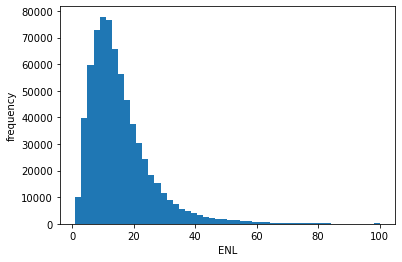

In [23]:
plt.hist(enl_img_ta[~np.isnan(enl_img_ta)], bins=50)
plt.xlabel('ENL')
plt.ylabel('frequency')

## Testing the Despeckling on a Subset

In [40]:
ratio_filled_c = ratio_hh_ts_nn[0][sy, sx]

In [41]:
if REGULARIZER == 'tv':
    regularizer_dict = {
                         'weight': 1
                        }
    
elif REGULARIZER == 'bm3d':
    regularizer_dict = {
                         'weight': .1
                        }
else:
    pass

In [45]:
ratio_den, res_list = admm_ratio_denoise(ratio_filled_c,
                                         L,
                                         Lm,
                                         REGULARIZER,
                                         regularizer_dict, 
                                         max_admm_iterations=10,
                                         newton_iterations=3
                                         )
ratio_den[mask_c] = np.nan

admm_iterations: 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


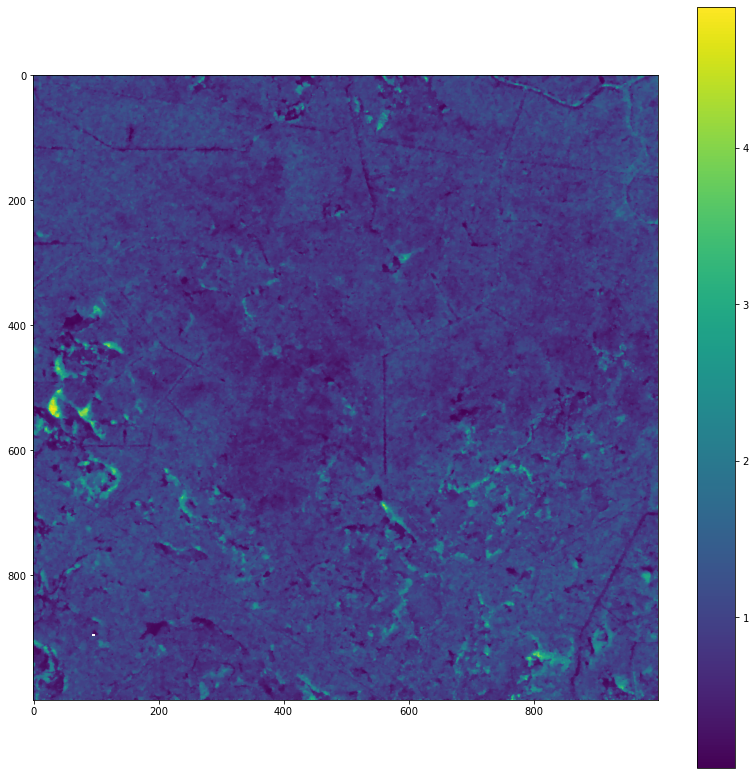

In [53]:
plt.subplots(figsize=(14, 14))
plt.imshow(ratio_den)
plt.colorbar()

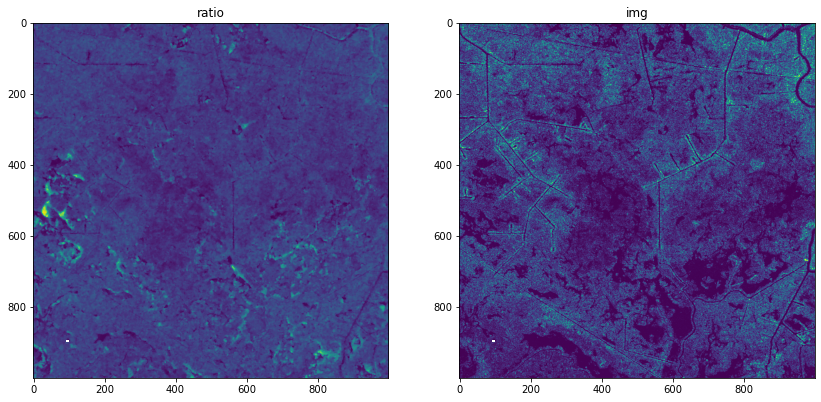

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(14, 14))
axs[0].imshow(ratio_den)
axs[0].set_title('ratio')
axs[1].set_title('img')
axs[1].imshow(img_c)

Text(0.5, 0, 'ADMM Iterations')

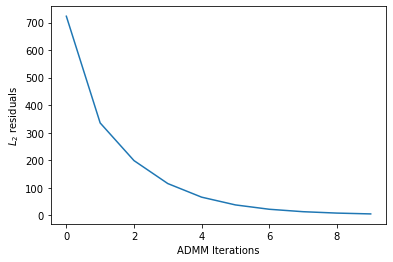

In [56]:
n = len(res_list)
plt.plot(np.arange(n), res_list)
plt.ylabel('$L_2$ residuals')
plt.xlabel('ADMM Iterations')

## Inspecting the Final Image

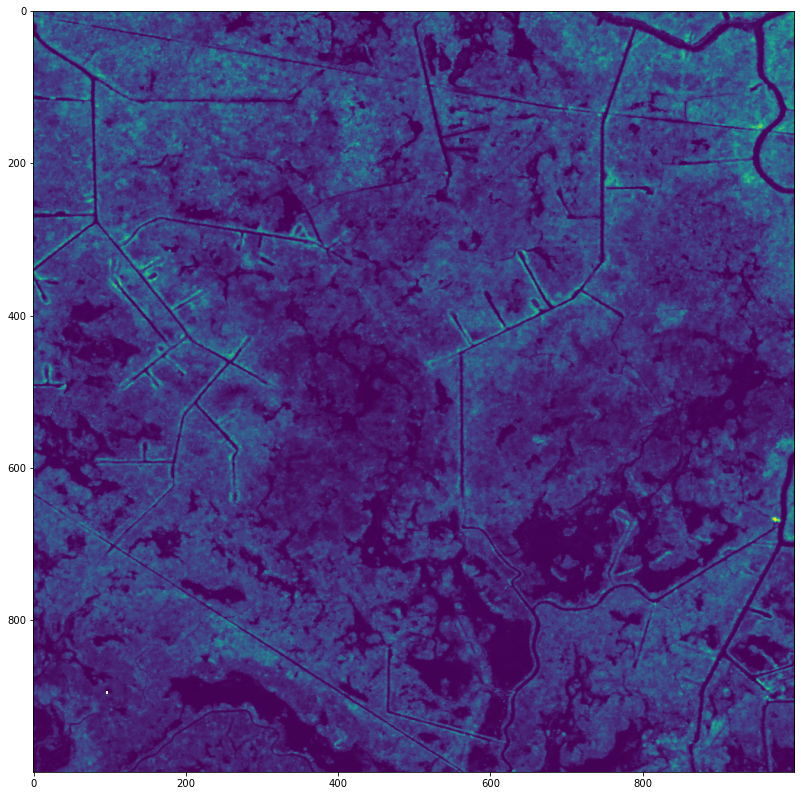

In [60]:
plt.subplots(figsize=(14, 14))
plt.imshow(ratio_den * ta_ref_c)

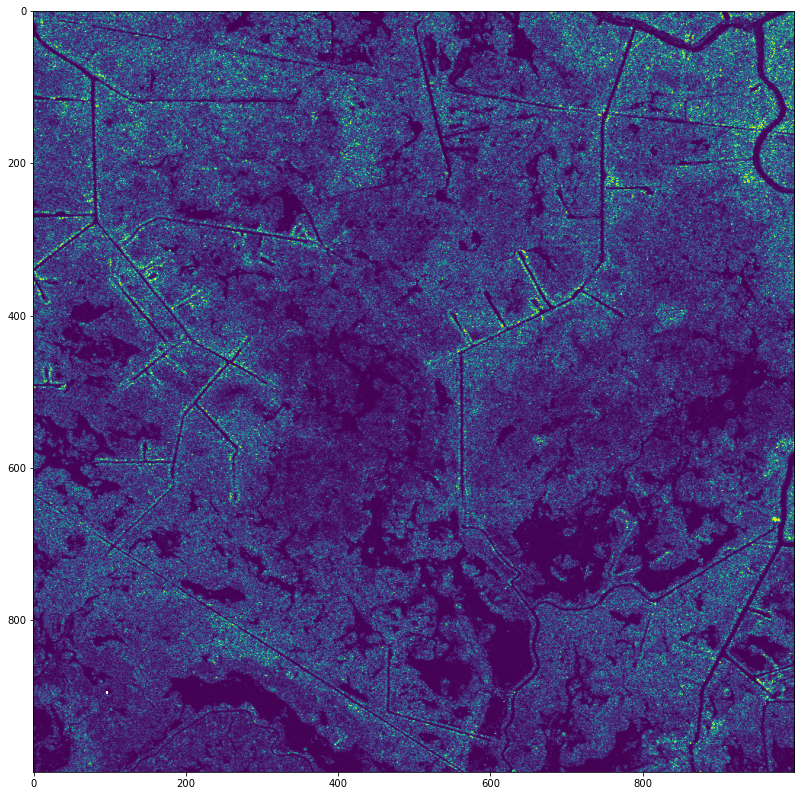

In [61]:
plt.subplots(figsize=(14, 14))
plt.imshow(img_c)

# Despeckle the Full Area and the Full Time Series

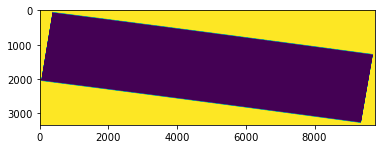

In [62]:
mask = np.isnan(hh_ts[0])
plt.imshow(mask)

In [72]:
def denoise_and_write_one_ratio_image(ratio, file_name, pol, weight):
    
    if pol == 'hh':
        ta_reference = ta_reference_image_hh
    if pol == 'hv':
        ta_reference = ta_reference_image_hv
    if pol == 'vv':
        ta_reference = ta_reference_image_vv
    
    regularizer_dict = {
                         'weight': weight
                        }
    
    ratio_den, res_list = admm_ratio_denoise(ratio,
                                             L,
                                             Lm,
                                             REGULARIZER,
                                             regularizer_dict, 
                                             max_admm_iterations=10,
                                             newton_iterations=3
                                             )
    
    despeckled_final = ratio_den * ta_reference
    despeckled_final = np.clip(despeckled_final, 1e-3, 1)
    despeckled_final[mask] = np.nan
    ratio_den[mask] = np.nan
    
    dest_dir_ratio = Path(f'{str(RATIO_DIR)}')/f'ratio_weight_{weight:1.2f}'/pol
    dest_dir_ratio.mkdir(exist_ok=True, parents=True)
    
    dest_dir_final = Path(f'{str(RATIO_DIR)}')/f'final_weight_{weight:1.2f}'/pol
    dest_dir_final.mkdir(exist_ok=True, parents=True)
    
    dest_ratio_path = dest_dir_ratio/file_name.replace('.tif', f'_weight={weight:1.2f}.tif')
    with rasterio.open(dest_ratio_path, 'w', **profile) as ds:
         ds.write(ratio_den, 1)
        
    dest_final_path = dest_dir_final/file_name.replace('.tif', f'_{REGULARIZER}_weight_{weight:1.2f}.tif')
    with rasterio.open(dest_final_path, 'w', **profile) as ds:
        ds.write(despeckled_final, 1)
    return dest_ratio_path, dest_final_path

In [73]:
hh_names = list(map(lambda x: x.name, hh_paths))
hv_names = list(map(lambda x: x.name, hv_paths))
vv_names = list(map(lambda x: x.name, vv_paths))

n = len(hv_names)

In [74]:
weight  = regularizer_dict['weight']
list(starmap(denoise_and_write_one_ratio_image, zip(tqdm(ratio_hh_ts_nn), hh_names, ['hh'] * n, [weight] * n)))
list(starmap(denoise_and_write_one_ratio_image, zip(tqdm(ratio_hv_ts_nn), hv_names, ['hv'] * n, [weight] * n)))
list(starmap(denoise_and_write_one_ratio_image, zip(tqdm(ratio_vv_ts_nn), vv_names, ['vv'] * n, [weight] * n)))

admm_iterations:  40%|████      | 4/10 [00:30<00:45,  7.55s/it]


admm_iterations:  90%|█████████ | 9/10 [01:08<00:07,  7.62s/it]


100%|██████████| 7/7 [09:44<00:00, 83.55s/it]


[(PosixPath('out/uavsar_waxlake_tv/rabasar_tv/ratio_weight_1.00/vv/uavsar_waxlake_vv_RTC_20190620_weight=1.00.tif'),
  PosixPath('out/uavsar_waxlake_tv/rabasar_tv/final_weight_1.00/vv/uavsar_waxlake_vv_RTC_20190620_tv_weight_1.00.tif')),
 (PosixPath('out/uavsar_waxlake_tv/rabasar_tv/ratio_weight_1.00/vv/uavsar_waxlake_vv_RTC_20190701_weight=1.00.tif'),
  PosixPath('out/uavsar_waxlake_tv/rabasar_tv/final_weight_1.00/vv/uavsar_waxlake_vv_RTC_20190701_tv_weight_1.00.tif')),
 (PosixPath('out/uavsar_waxlake_tv/rabasar_tv/ratio_weight_1.00/vv/uavsar_waxlake_vv_RTC_20190716_weight=1.00.tif'),
  PosixPath('out/uavsar_waxlake_tv/rabasar_tv/final_weight_1.00/vv/uavsar_waxlake_vv_RTC_20190716_tv_weight_1.00.tif')),
 (PosixPath('out/uavsar_waxlake_tv/rabasar_tv/ratio_weight_1.00/vv/uavsar_waxlake_vv_RTC_20190725_weight=1.00.tif'),
  PosixPath('out/uavsar_waxlake_tv/rabasar_tv/final_weight_1.00/vv/uavsar_waxlake_vv_RTC_20190725_tv_weight_1.00.tif')),
 (PosixPath('out/uavsar_waxlake_tv/rabasar_tv/ra

# Make RGBs (Optional)

In [22]:
rabasar_dir = Path(f'{str(RATIO_DIR)}')/'final'/f'lamb={lamb_r:1.2f}'
rabasar_dir.exists()

True

In [23]:
hh_paths_rabasar = sorted(list(rabasar_dir.glob('*/*hh*.tif')))
hv_paths_rabasar = sorted(list(rabasar_dir.glob('*/*hv*.tif')))
vv_paths_rabasar = sorted(list(rabasar_dir.glob('*/*vv*.tif')))

hv_paths

[PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190620.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190701.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190716.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190725.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190812.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190923.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190930.tif')]

In [34]:
hh_names = list(map(lambda x: x.name, hh_paths))
hv_names = list(map(lambda x: x.name, hv_paths))
vv_names = list(map(lambda x: x.name, vv_paths))

n = len(hv_names)

In [24]:
hh_rabasar = list(map(open_one, tqdm(hh_paths_rabasar)))
hv_rabasar = list(map(open_one, tqdm(hv_paths_rabasar)))
vv_rabasar = list(map(open_one, tqdm(vv_paths_rabasar)))


100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


In [25]:
hh_rabasar[0]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [26]:
hh_rabasar[0].shape, hv_rabasar[0].shape, vv_rabasar[0].shape

((3335, 9757), (3335, 9757), (3335, 9757))

In [28]:
def make_rgb_db(hh, hv, vv):
    stack = [10 * np.log10(hh),
             10 * np.log10(hv),
             10 * np.log10(vv)]
    stack = np.stack(stack, axis=2)
    stack = np.clip(stack, -30, 0)
    return scale_img(stack)


def make_rgb(hh, hv, vv):
    stack = [(hh),
             (hv),
             (vv)]
    stack = np.stack(stack, axis=2)
    return scale_img(stack)

ind = 0
rgb = make_rgb(hh_rabasar[ind], hv_rabasar[ind], vv_rabasar[ind])
rgb_db = make_rgb_db(hh_rabasar[ind], hv_rabasar[ind], vv_rabasar[ind])


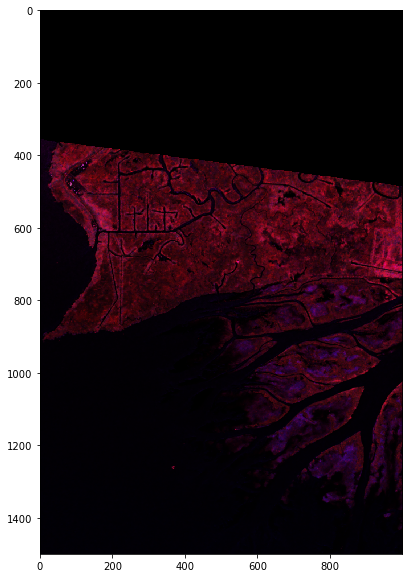

In [29]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb[:1500, 2000:3000])

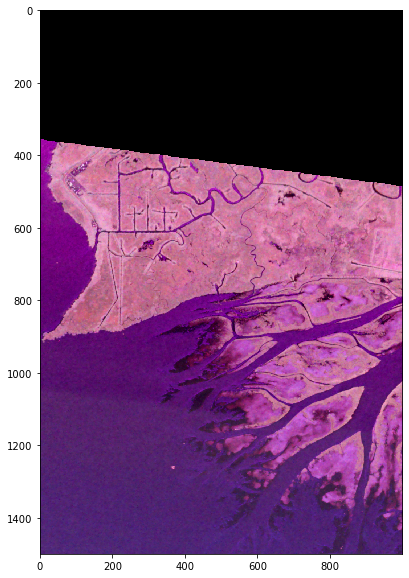

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb_db[:1500, 2000:3000])

In [31]:
LAMBDA_R = 2


In [44]:
rgb_db_dir = Path(f'out/rabasar_rgb_db_lamb={LAMBDA_R:1.2f}')
rgb_db_dir.mkdir(exist_ok=True, parents=True)

In [45]:
rgb_dir = Path(f'out/rabasar_rgb_lamb={LAMBDA_R:1.2f}')
rgb_dir.mkdir(exist_ok=True, parents=True)

In [46]:
def make_and_write_rgb(hh, hv, vv, file_name, scale):
    if scale == 'db':
        dest_dir = rgb_db_dir
        rgb_func = make_rgb_db
    elif scale == 'linear':
        dest_dir = rgb_dir
        rgb_func = make_rgb
    else:
        raise ValueError('Unspecified scale; must be linear or db')
        
    rgb = rgb_func(hh, hv, vv)
    p_rgb = profile.copy()
    p_rgb['count'] = 3
    
    file_name = (file_name[:11] +
                 'rgb'+
                 file_name[13:-4]
                 + f'_lamb={LAMBDA_R:1.2f}.tif')
    
    dest_path = dest_dir/file_name
    with rasterio.open(dest_path, 'w', **p_rgb) as ds:
        ds.write(rgb.transpose([2, 0, 1]).astype(np.float32))
    return dest_path

In [47]:
list(starmap(make_and_write_rgb, zip(tqdm(hh_rabasar), hv_rabasar, vv_rabasar, hh_names, ['linear'] * n)))

100%|██████████| 7/7 [00:14<00:00,  2.09s/it]


[PosixPath('out/rabasar_rgb_lamb=2.00/UAVSAR_RTC_rgb_20190620_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_lamb=2.00/UAVSAR_RTC_rgb_20190701_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_lamb=2.00/UAVSAR_RTC_rgb_20190716_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_lamb=2.00/UAVSAR_RTC_rgb_20190725_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_lamb=2.00/UAVSAR_RTC_rgb_20190812_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_lamb=2.00/UAVSAR_RTC_rgb_20190923_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_lamb=2.00/UAVSAR_RTC_rgb_20190930_lamb=2.00.tif')]

In [49]:
list(starmap(make_and_write_rgb, zip(tqdm(hh_rabasar), hv_rabasar, vv_rabasar, hh_names, ['db'] * n)))

100%|██████████| 7/7 [00:15<00:00,  2.28s/it]


[PosixPath('out/rabasar_rgb_db_lamb=2.00/UAVSAR_RTC_rgb_20190620_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_db_lamb=2.00/UAVSAR_RTC_rgb_20190701_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_db_lamb=2.00/UAVSAR_RTC_rgb_20190716_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_db_lamb=2.00/UAVSAR_RTC_rgb_20190725_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_db_lamb=2.00/UAVSAR_RTC_rgb_20190812_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_db_lamb=2.00/UAVSAR_RTC_rgb_20190923_lamb=2.00.tif'),
 PosixPath('out/rabasar_rgb_db_lamb=2.00/UAVSAR_RTC_rgb_20190930_lamb=2.00.tif')]